In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores

from apa_utils import load_apa_data, load_apa_predictor_cleavage_logodds, animate_apa_examples


2021-12-08 22:33:04.745053: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


2021-12-08 22:33:07.516820: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 22:33:07.518454: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-08 22:33:07.580217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 22:33:07.581184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.3

In [2]:
#Load APA data and predictor

encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

data_path = 'apa_doubledope_cached_set.csv'

x_train, y_train, x_test, y_test = load_apa_data(data_path, encoder)

predictor_path = 'saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

predictor = load_apa_predictor_cleavage_logodds(predictor_path)


len(data_df) = 34748 (loaded)
x_train.shape = (32992, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (32992, 1)
y_test.shape = (1728, 1)


2021-12-08 22:33:13.333578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-08 22:33:13.351994: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300015000 Hz


In [3]:
#Print predictor input/output details

print("predictor.inputs = " + str(predictor.inputs))
print("predictor.outputs = " + str(predictor.outputs))


predictor.inputs = [<tf.Tensor 'seq_input:0' shape=(?, 205, 4) dtype=float32>, <tf.Tensor 'lib_input:0' shape=(?, 13) dtype=float32>, <tf.Tensor 'distal_pas_input:0' shape=(?, 1) dtype=float32>]
predictor.outputs = [<tf.Tensor 'rel_cut_logodds/Log:0' shape=(?, 4) dtype=float32>]


In [4]:
#Define sequence template and background

sequence_template = 'CTTCCGATCT$$$$$$$$$$$$$$$$$$$$CATTACTCGCATCCA$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$CAGCCAATTAAGCC$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$CTAC'

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)


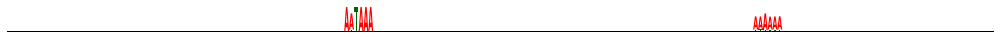

In [5]:
#Visualize background sequence distribution

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205)


In [6]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.8729476983107292


In [7]:
#For the sake of the example, lets transform x to a 1d shape

x_train = x_train[:, 0, ...]
x_test = x_test[:, 0, ...]

print(x_train.shape)
print(x_test.shape)


(32992, 205, 4)
(1728, 205, 4)


In [8]:
#Create extra inputs that the predictor model expects

feat_1_train = np.zeros((x_train.shape[0], 13))
feat_1_test = np.zeros((x_test.shape[0], 13))
feat_1_train[:, 4] = 1.
feat_1_test[:, 4] = 1.

feat_2_train = np.ones((x_train.shape[0], 1))
feat_2_test = np.ones((x_test.shape[0], 1))

print(feat_1_train.shape)
print(feat_2_train.shape)


(32992, 13)
(32992, 1)


In [9]:

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : True,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}


In [11]:
#Train scrambler(s) to maximize cleavage logodds at different positions

save_dir = 'saved_models'

for cut_pos in [0, 1, 2, 3] :

    print("Training scrambler for cleavage position = " + str(cut_pos) + ".")
    
    #Initialize scrambler
    scrambler = Scrambler(
        scrambler_mode='inclusion',
        input_size_x=None,
        input_size_y=205,
        n_out_channels=4,
        n_classes=4,
        input_templates=[onehot_template],
        input_backgrounds=[x_mean],
        batch_size=32,
        n_samples=32,
        sample_mode='gumbel',
        zeropad_input=False,
        mask_dropout=False,
        network_config=network_config
    )

    #y_pred_scrambled.shape = (batch_size, n_samples, n_classes)
    def maximize_cleavage_logodds(y_pred_non_scrambled, y_pred_scrambled, cut_pos=cut_pos) :

        return -K.mean(y_pred_scrambled[..., cut_pos], axis=-1)

    n_epochs = 10

    _ = scrambler.train(
        predictor,
        x_train,
        y_train,
        x_test,
        y_test,
        n_epochs,
        extra_input_train=[feat_1_train, feat_2_train],
        extra_input_test=[feat_1_test, feat_2_test],
        monitor_test_indices=None,
        custom_loss_func=maximize_cleavage_logodds,
        entropy_mode='target',
        entropy_bits=0.1,
        entropy_weight=20.
    )
    
    #Save scrambler checkpoint

    model_name = 'apa_inclusion_scrambler_smooth_target_bits_01_epochs_10_deeper_cut_pos_' + str(cut_pos)

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '.h5')

    scrambler.save_model(model_path)


Training scrambler for cleavage position = 0.
Train on 32992 samples, validate on 1728 samples
Epoch 1/10
32992/32992 [==============================] - 48s 1ms/sample - loss: 3.7865 - nll_loss: 3.3311 - entropy_loss: 0.4554 - val_loss: 3.2748 - val_nll_loss: 3.1947 - val_entropy_loss: 0.0800
Epoch 2/10
32992/32992 [==============================] - 48s 1ms/sample - loss: 3.2224 - nll_loss: 3.1654 - entropy_loss: 0.0570 - val_loss: 3.1827 - val_nll_loss: 3.1087 - val_entropy_loss: 0.0741
Epoch 3/10
32992/32992 [==============================] - 60s 2ms/sample - loss: 3.1521 - nll_loss: 3.0913 - entropy_loss: 0.0608 - val_loss: 3.1395 - val_nll_loss: 3.1066 - val_entropy_loss: 0.0328
Epoch 4/10
32992/32992 [==============================] - 61s 2ms/sample - loss: 3.1169 - nll_loss: 3.0546 - entropy_loss: 0.0623 - val_loss: 3.1052 - val_nll_loss: 3.0515 - val_entropy_loss: 0.0538
Epoch 5/10
32992/32992 [==============================] - 61s 2ms/sample - loss: 3.0922 - nll_loss: 3.0283 - 

32992/32992 [==============================] - 43s 1ms/sample - loss: 3.6238 - nll_loss: 3.5054 - entropy_loss: 0.1184 - val_loss: 3.6256 - val_nll_loss: 3.4878 - val_entropy_loss: 0.1378
Epoch 9/10
32992/32992 [==============================] - 44s 1ms/sample - loss: 3.6104 - nll_loss: 3.4906 - entropy_loss: 0.1197 - val_loss: 3.6100 - val_nll_loss: 3.5006 - val_entropy_loss: 0.1094
Epoch 10/10
32992/32992 [==============================] - 44s 1ms/sample - loss: 3.5933 - nll_loss: 3.4693 - entropy_loss: 0.1240 - val_loss: 3.5935 - val_nll_loss: 3.4747 - val_entropy_loss: 0.1189
Saved scrambler model at saved_models/apa_inclusion_scrambler_smooth_target_bits_01_epochs_10_deeper_cut_pos_3.h5 


In [12]:
#Load models and interpret test patterns for all cleavage positions

save_dir = 'saved_models'

pwm_test = []
sample_test = []
importance_scores_test = []

for cut_pos in [0, 1, 2, 3] :

    print("Interpreting for cleavage position = " + str(cut_pos) + ".")

    model_name = 'apa_inclusion_scrambler_smooth_target_bits_01_epochs_10_deeper_cut_pos_' + str(cut_pos)
    model_path = os.path.join(save_dir, model_name + '.h5')

    scrambler.load_model(model_path)
    
    #Interpret the test set using the trained scrambler
    pwm_t, sample_t, importance_scores_t = scrambler.interpret(x_test)

    pwm_test.append(pwm_t[None, ...])
    sample_test.append(sample_t[None, ...])
    importance_scores_test.append(importance_scores_t[None, ...])

pwm_test = np.concatenate(pwm_test, axis=0)
sample_test = np.concatenate(sample_test, axis=0)
importance_scores_test = np.concatenate(importance_scores_test, axis=0)


Interpreting for cleavage position = 0.
Loaded scrambler model from saved_models/apa_inclusion_scrambler_smooth_target_bits_01_epochs_10_deeper_cut_pos_0.h5 
Interpreting for cleavage position = 1.
Loaded scrambler model from saved_models/apa_inclusion_scrambler_smooth_target_bits_01_epochs_10_deeper_cut_pos_1.h5 
Interpreting for cleavage position = 2.
Loaded scrambler model from saved_models/apa_inclusion_scrambler_smooth_target_bits_01_epochs_10_deeper_cut_pos_2.h5 
Interpreting for cleavage position = 3.
Loaded scrambler model from saved_models/apa_inclusion_scrambler_smooth_target_bits_01_epochs_10_deeper_cut_pos_3.h5 


Test sequence 3:


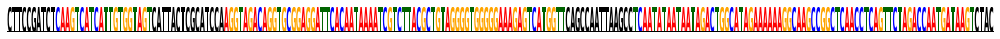

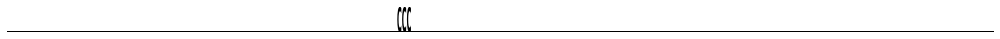

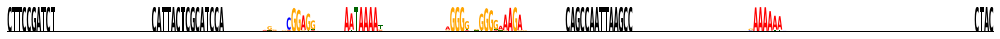

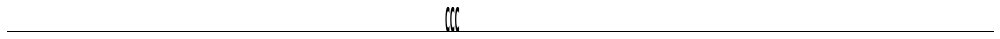

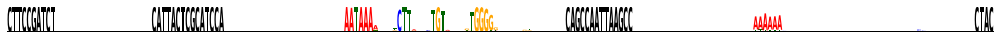

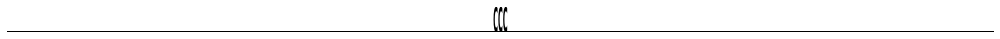

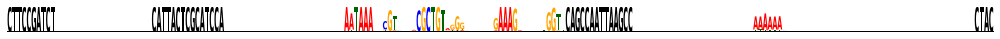

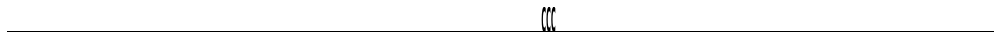

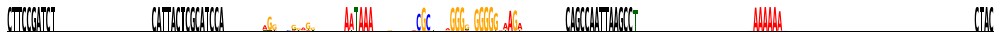

Test sequence 5:


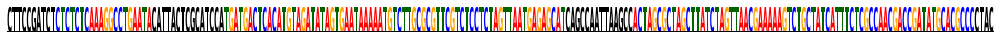

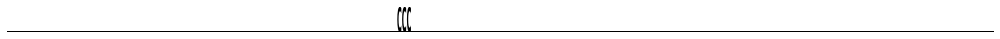

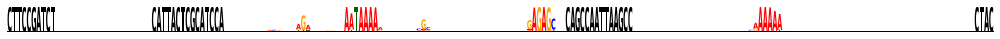

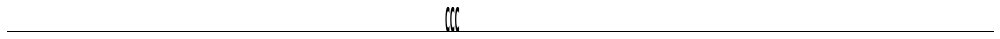

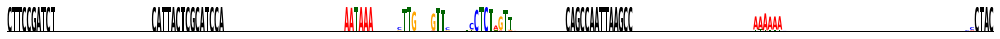

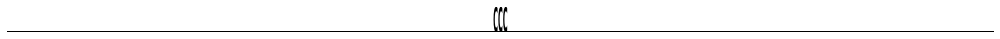

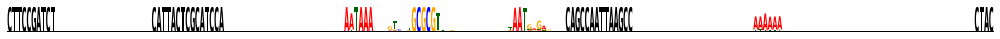

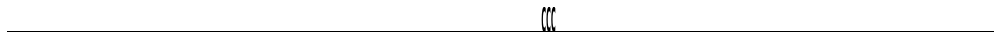

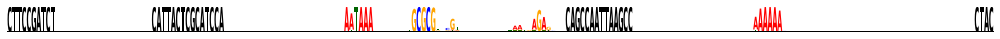

Test sequence 6:


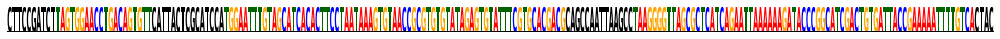

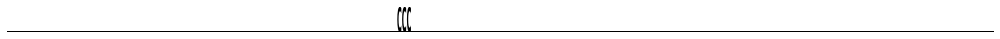

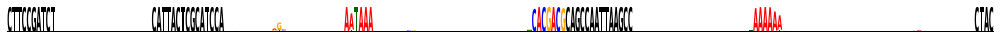

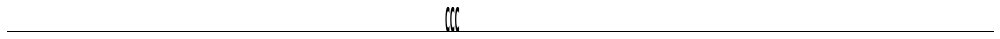

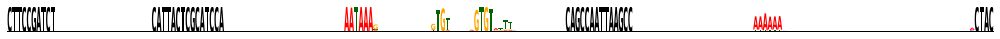

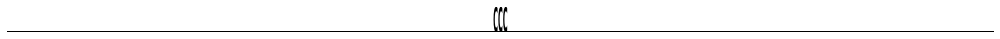

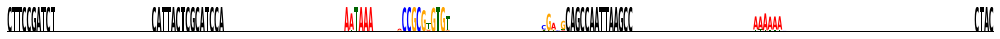

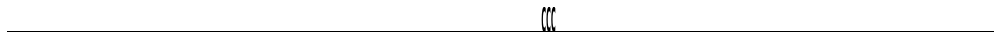

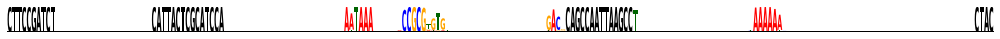

In [13]:
#Visualize a few reconstructed sequence patterns

importance_scores_test *= sequence_mask[None, None, :, None]

plot_examples = [3, 5, 6]
save_examples = []

cuts = [76 + 5, 76 + 15, 76 + 25, 76 + 35]

for test_ix in plot_examples :
    
    print("Test sequence " + str(test_ix) + ":")
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    plot_dna_logo(x_test[test_ix, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence")
    
    #Plot interpretation PWM for each cleavage position
    for cut_ix, cut_pos in enumerate([0, 1, 2, 3]) :
        #Mark the position where we are maximizing cleavage
        cut_template = 'N' * 205
        cut_template = cut_template[:cuts[cut_ix]] + 'CCC' + cut_template[cuts[cut_ix]+1:]
        plot_dna_logo(np.zeros((205, 4)), sequence_template=cut_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm")
        #Plot Scrambler interpretation (PWM)
        plot_dna_logo(pwm_test[cut_ix, test_ix, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm")
